In [11]:
#Importing necessary libraries

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup


In [3]:
nltk.download('stopwords')
nltk.download('punkt_tab')
Stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\arvenka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\arvenka\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [4]:
# Load the CSV file 
data = pd.read_csv('dataset/twitter_training.csv',encoding='utf-8')
data.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [5]:
data.columns = ['ID', 'Brand', 'Sentiment', 'Phrase']
data.head()

,ID,Brand,Sentiment,Phrase
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         74681 non-null  int64 
 1   Brand      74681 non-null  object
 2   Sentiment  74681 non-null  object
 3   Phrase     73995 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [7]:
data.isnull().sum()

ID             0
Brand          0
Sentiment      0
Phrase       686
dtype: int64

In [42]:
MAX_NUM_WORDS = 5000
MAX_SEQUENCE_LENGTH = 100

In [43]:
def cleaning(raw_review):
    import nltk

    # 1. To string
    to_string = str(raw_review) 
    
    # 2. Remove non-letters.
    letters = re.sub("[^a-zA-Z]", " ", to_string)
    
    # 3. Convert to lower case.
    letters = letters.lower()
    
    # 4. Tokenize.
    tokens = nltk.word_tokenize(letters)
    
    # 5. Convert the stopwords list to "set" data type.
    stops = set(nltk.corpus.stopwords.words("english"))
    
    # 6. Remove stop words. 
    words = [w for w in tokens if not w in stops]
    
    # 7. Stemming
    words = [nltk.stem.SnowballStemmer('english').stem(w) for w in words]
    
    # 8. Join the words back into one string separated by space, and return the result.
    return " ".join(words)

In [37]:
cleaning(data['Phrase'].tolist()[13])

'rock hard la varlop rare power handsom jackpot borderland xbox dfr rmtrgf'

In [26]:

# Apply the preprocess function to the 'text' column
data['cleaned_text'] = data['Phrase'].apply(cleaning)

print(data['cleaned_text'].head())


0             come border kill
1       im get borderland kill
2    im come borderland murder
3     im get borderland murder
4     im get borderland murder
Name: cleaned_text, dtype: object


In [27]:
data['Sentiment'].unique()

array(['Positive', 'Neutral', 'Negative', 'Irrelevant'], dtype=object)

In [38]:
# Encode the sentiment labels (e.g., positive=2, neutral=1, negative=0)
label_encoder = LabelEncoder()
data['sentiment_encoded'] = label_encoder.fit_transform(data['Sentiment'])

# Convert sentiment to categorical for model training
y = to_categorical(data['sentiment_encoded'])
y

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

In [46]:
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(data['cleaned_text'].values)
X = tokenizer.texts_to_sequences(data['cleaned_text'].values)

In [47]:
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

In [48]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
# Define the model architecture
model = Sequential()
model.add(Embedding(MAX_NUM_WORDS, 128, input_length=MAX_SEQUENCE_LENGTH))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(4, activation='softmax'))  # 4 output units for 4 sentiment categories

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

C:\Users\arvenka\AppData\Local\anaconda3\envs\tensorflow\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │   0 (unbuilt) │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [50]:
# Train the model with validation split
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=2
)

Epoch 1/10
1867/1867 - 79s - 42ms/step - accuracy: 0.6016 - loss: 0.9639 - val_accuracy: 0.6777 - val_loss: 0.7919
Epoch 2/10
1867/1867 - 77s - 41ms/step - accuracy: 0.7263 - loss: 0.6951 - val_accuracy: 0.7281 - val_loss: 0.6847
Epoch 3/10
1867/1867 - 80s - 43ms/step - accuracy: 0.7749 - loss: 0.5787 - val_accuracy: 0.7613 - val_loss: 0.6189
Epoch 4/10
1867/1867 - 81s - 43ms/step - accuracy: 0.8060 - loss: 0.5013 - val_accuracy: 0.7718 - val_loss: 0.5942
Epoch 5/10
1867/1867 - 78s - 42ms/step - accuracy: 0.8241 - loss: 0.4485 - val_accuracy: 0.7881 - val_loss: 0.5602
Epoch 6/10
1867/1867 - 83s - 45ms/step - accuracy: 0.8439 - loss: 0.4002 - val_accuracy: 0.8003 - val_loss: 0.5408
Epoch 7/10
1867/1867 - 88s - 47ms/step - accuracy: 0.8591 - loss: 0.3620 - val_accuracy: 0.8124 - val_loss: 0.5223
Epoch 8/10
1867/1867 - 85s - 46ms/step - accuracy: 0.8694 - loss: 0.3351 - val_accuracy: 0.8184 - val_loss: 0.5244
Epoch 9/10
1867/1867 - 100s - 53ms/step - accuracy: 0.8779 - loss: 0.3076 - val_

467/467 - 8s - 17ms/step - accuracy: 0.8348 - loss: 0.5067
Validation Loss: 0.5067, Validation Accuracy: 0.8348


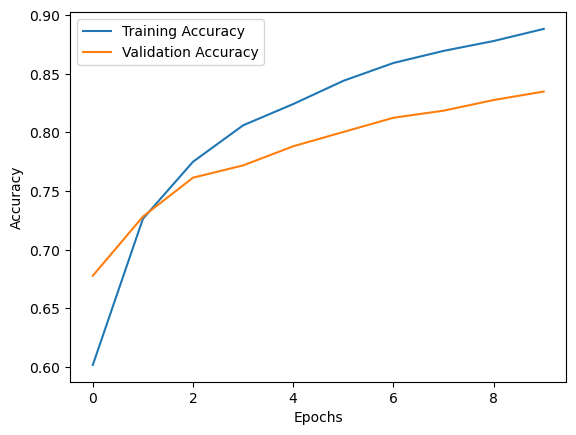

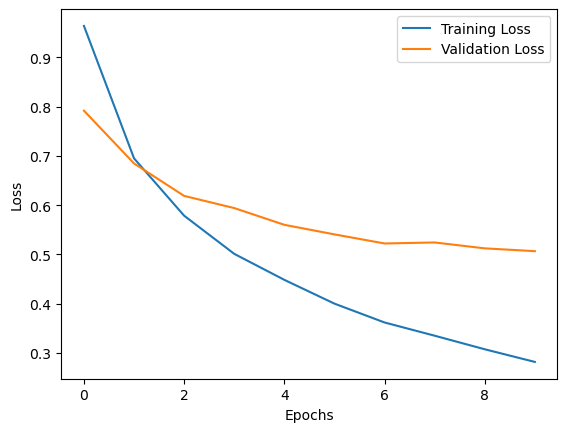

In [51]:
# Evaluate the model on the validation set
loss, accuracy = model.evaluate(X_val, y_val, verbose=2)
print(f'Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}')

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()